In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)

In [3]:
# MultiHeadAttention
# https://www.tensorflow.org/tutorials/text/transformer, appears in "Attention is all you need" NIPS 2018 paper
import numpy as np
import tensorflow as tf


def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)
    
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [4]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

    
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0
    
        self.depth = d_model // self.num_heads
    
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output
    

# temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
# y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
# out = temp_mha(v=y, k=y, q=y)
# print(out.shape)


class RFF(tf.keras.layers.Layer):
    """
    Row-wise FeedForward layers.
    """
    def __init__(self, d):
        super(RFF, self).__init__()
        
        self.linear_1 = Dense(d, activation='relu')
        self.linear_2 = Dense(d, activation='relu')
        self.linear_3 = Dense(d, activation='relu')
            
    def call(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, n, d].
        Returns:
            a float tensor with shape [b, n, d].
        """
        return self.linear_3(self.linear_2(self.linear_1(x)))   


# mlp = RFF(3)
# y = mlp(tf.ones(shape=(2, 4, 3)))  # The first call to the `mlp` will create the weights
# print('weights:', len(mlp.weights))
# print('trainable weights:', len(mlp.trainable_weights))

In [27]:
# Referencing https://arxiv.org/pdf/1810.00825.pdf 
# and the original PyTorch implementation https://github.com/TropComplique/set-transformer/blob/master/blocks.py
from tensorflow import repeat
# from tensorflow.keras.backend import repeat_elements
from tensorflow.keras.layers import LayerNormalization


class MultiHeadAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, d, h, rff):
        super(MultiHeadAttentionBlock, self).__init__()
        self.multihead = MultiHeadAttention(d, h)
        self.layer_norm1 = LayerNormalization(epsilon=1e-6, dtype='float32')
        self.layer_norm2 = LayerNormalization(epsilon=1e-6, dtype='float32')
        self.rff = rff
    
    def call(self, x, y):
        """
        Arguments:
            x: a float tensor with shape [b, n, d].
            y: a float tensor with shape [b, m, d].
        Returns:
            a float tensor with shape [b, n, d].
        """
    
        h = self.layer_norm1(x + self.multihead(x, y, y))
        return self.layer_norm2(h + self.rff(h))

# x_data = tf.random.normal(shape=(10, 2, 9))
# y_data = tf.random.normal(shape=(10, 3, 9))
# rff = RFF(d=9)
# mab = MultiHeadAttentionBlock(9, 3, rff=rff)
# mab(x_data, y_data).shape    

    
class SetAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, d, h, rff):
        super(SetAttentionBlock, self).__init__()
        self.mab = MultiHeadAttentionBlock(d, h, rff)
    
    def call(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, n, d].
        Returns:
            a float tensor with shape [b, n, d].
        """
        return self.mab(x, x)

    
class InducedSetAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, d, m, h, rff1, rff2):
        """
        Arguments:
            d: an integer, input dimension.
            m: an integer, number of inducing points.
            h: an integer, number of heads.
            rff1, rff2: modules, row-wise feedforward layers.
                It takes a float tensor with shape [b, n, d] and
                returns a float tensor with the same shape.
        """
        super(InducedSetAttentionBlock, self).__init__()
        self.mab1 = MultiHeadAttentionBlock(d, h, rff1)
        self.mab2 = MultiHeadAttentionBlock(d, h, rff2)
        self.inducing_points = tf.random.normal(shape=(1, m, d))

    def call(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, n, d].
        Returns:
            a float tensor with shape [b, n, d].
        """
        b = tf.shape(x)[0] 
        p = self.inducing_points
        p = repeat(p, (b), axis=0)  # shape [b, m, d]  
        
        h = self.mab1(p, x)  # shape [b, m, d]
        return self.mab2(x, h)     
    

class PoolingMultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d, k, h, rff, rff_s):
        """
        Arguments:
            d: an integer, input dimension.
            k: an integer, number of seed vectors.
            h: an integer, number of heads.
            rff: a module, row-wise feedforward layers.
                It takes a float tensor with shape [b, n, d] and
                returns a float tensor with the same shape.
        """
        super(PoolingMultiHeadAttention, self).__init__()
        self.mab = MultiHeadAttentionBlock(d, h, rff)
        self.seed_vectors = tf.random.normal(shape=(1, k, d))
        self.rff_s = rff_s

    @tf.function
    def call(self, z):
        """
        Arguments:
            z: a float tensor with shape [b, n, d].
        Returns:
            a float tensor with shape [b, k, d]
        """
        b = tf.shape(z)[0]
        s = self.seed_vectors
        s = repeat(s, (b), axis=0)  # shape [b, k, d]
        return self.mab(s, self.rff_s(z))
    

# z = tf.random.normal(shape=(10, 2, 9))
# rff, rff_s = RFF(d=9), RFF(d=9) 
# pma = PoolingMultiHeadAttention(d=9, k=10, h=3, rff=rff, rff_s=rff_s)
# pma(z).shape

In [28]:
from tensorflow.keras.layers import Dense
    

class STEncoderBasic(tf.keras.layers.Layer):
    def __init__(self, d=12, m=6, h=6):
        super(STEncoderBasic, self).__init__()
        
        # Embedding part
        self.linear_1 = Dense(d, activation='relu')
        
        # Encoding part
        self.isab_1 = InducedSetAttentionBlock(d, m, h, RFF(d), RFF(d))
        self.isab_2 = InducedSetAttentionBlock(d, m, h, RFF(d), RFF(d))
            
    def call(self, x):
        return self.isab_2(self.isab_1(self.linear_1(x)))

    
class STDecoderBasic(tf.keras.layers.Layer):
    def __init__(self, out_dim, d=12, m=6, h=2, k=8):
        super(STDecoderBasic, self).__init__()
        
        self.PMA = PoolingMultiHeadAttention(d, k, h, RFF(d), RFF(d))
        self.SAB = SetAttentionBlock(d, h, RFF(d))
        self.output_mapper = Dense(out_dim)   
        self.k, self.d = k, d

    def call(self, x):
        decoded_vec = self.SAB(self.PMA(x))
        decoded_vec = tf.reshape(decoded_vec, [-1, self.k * self.d])
        return tf.reshape(self.output_mapper(decoded_vec), (tf.shape(decoded_vec)[0],))


In [29]:
def gen_max_dataset(dataset_size=100000, set_size=9):
    """
    The number of objects per set is constant in this toy example
    """
    x = np.random.uniform(1, 100, (dataset_size, set_size))
    y = np.max(x, axis=1)
    x, y = np.expand_dims(x, axis=2), np.expand_dims(y, axis=1)
    return tf.cast(x, 'float32'), tf.cast(y, 'float32')

X, y = gen_max_dataset()
X.shape

TensorShape([100000, 9, 1])

In [30]:
# Dimensionality check on encoder-decoder couple

encoder = STEncoderBasic(d=3, m=2, h=1)
encoded = encoder(X)
print(encoded.shape)

decoder = STDecoderBasic(out_dim=1, d=1, m=2, h=1, k=1)
decoded = decoder(encoded)
print(decoded.shape)

(100000, 9, 3)
(100000,)


In [31]:
# Actual model for max-set prediction

class SetTransformer(tf.keras.Model):
    def __init__(self, ):
        super(SetTransformer, self).__init__()
        self.basic_encoder = STEncoderBasic(d=4, m=3, h=2)
        self.basic_decoder = STDecoderBasic(out_dim=1, d=4, m=2, h=2, k=2)
    
    def call(self, x):
        enc_output = self.basic_encoder(x)  # (batch_size, set_len, d_model)
        return self.basic_decoder(enc_output)

In [32]:
set_transformer = SetTransformer()
set_transformer.compile(loss='mae', optimizer='adam')
set_transformer.fit(X, y, epochs=6)

Train on 100000 samples
Epoch 1/6
100000/100000 [==============================] - 24s 237us/sample - loss: 29.9259
Epoch 2/6
100000/100000 [==============================] - 21s 206us/sample - loss: 2.5411
Epoch 3/6
100000/100000 [==============================] - 20s 199us/sample - loss: 0.5547
Epoch 4/6
100000/100000 [==============================] - 20s 199us/sample - loss: 0.4607
Epoch 5/6
100000/100000 [==============================] - 20s 199us/sample - loss: 0.4181
Epoch 6/6
100000/100000 [==============================] - 21s 205us/sample - loss: 0.4109


In [116]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [119]:
import numpy as np
from typing import List, Tuple

def extract_image_set(x_data: np.array, y_data :np.array, agg_fun=np.sum, n_images=3) -> Tuple[np.array, np.array]:
    """
    Extract a single set of images with corresponding target
    :param x_data
    """
    idxs = np.random.randint(low=0, high=len(x_data)-1, size=n_images)
    return x_data[idxs], agg_fun(y_data[idxs])


def generate_dataset(n_samples: int, x_data: np.array, y_data :np.array, agg_fun=np.sum, n_images=3) -> Tuple[List[List[np.array]], np.array]:
    """
    :return X,y in format suitable for training/prediction 
    """
    generated_list = [extract_image_set(x_data, y_data, agg_fun, n_images) for i in range(n_samples)]
    X, y = [i[0] for i in generated_list], np.array([t[1] for t in generated_list])
    output_lists = [[] for i in range(n_images)]
    for image_idx in range(n_images):
        for sample_idx in range(n_samples):
            output_lists[image_idx].append(np.expand_dims(X[sample_idx][image_idx], axis=2))
    return output_lists, y

X_train_data, y_train_data = generate_dataset(n_samples=100000, x_data=x_train, y_data=y_train, n_images=3)
X_test_data, y_test_data = generate_dataset(n_samples=20000, x_data=x_test, y_data=y_test, n_images=3)

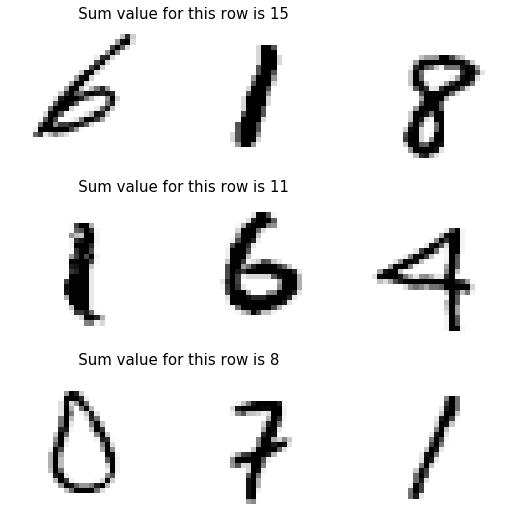

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline 

n_sample_viz, n_images = 3, 3

fig, axes = plt.subplots(nrows=n_sample_viz, ncols=n_images, figsize=(9.0, 9.0))

for sample_idx in range(n_sample_viz):
    for im_idx in range(n_images):
        axes[sample_idx, im_idx].imshow(X_train_data[im_idx][sample_idx][:, :, 0], cmap='Greys')
        axes[sample_idx, im_idx].axis('off')
        if im_idx==0:
            axes[sample_idx, 0].set_title('               Sum value for this row is {}'.format(y_train_data[sample_idx]), 
                                    fontsize=15, loc='left')

In [111]:
# First, define the vision modules
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Add
from tensorflow.keras.optimizers import Adam

filters = 64
kernel_size = 3

import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = [np.expand_dims(t, axis=2) for t in x_train]
x_test = [np.expand_dims(t, axis=2) for t in x_test]

input_image = Input(shape=(28, 28, 1))

y = Conv2D(32, kernel_size=(3, 3),
           activation='relu',
           input_shape=input_shape)(input_image)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Dropout(0.25)(y)
y = Flatten()(y)
y = Dense(32, activation='relu')(y)
y = Dense(16, activation='relu')(y)
output_vec = Dense(1)(y)

vision_model = Model(input_image, output_vec)
vision_model.compile(loss='mae')
vision_model.fit(np.array(x_train), np.array(y_train), epochs=3, batch_size=64)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 77s 1ms/sample - loss: 1.0678
Epoch 2/3
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.5569
Epoch 3/3
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.4641


In [112]:
vision_model.save('vision_model.h5')

In [2]:
import numpy as np

x = np.random.uniform(1, 100, (10, 3))
x = np.expand_dims(x, axis=2)
x.shape

(10, 3, 1)